In [1]:
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
import tensorflow as tf
%matplotlib inline

In [2]:
with open('BTC_hist_daily_prices.json') as json_file:
    data = json.load(json_file)

df = pd.DataFrame(data['Data']['Data'])
df = df.set_index('time')
df.index = pd.to_datetime(df.index, unit='s')
df = df.drop(['conversionType', 'conversionSymbol'], axis=1 )
target_col = 'close'

df.head(100)

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2010-07-17,0.04951,0.04951,0.04951,20.00,0.9902,0.04951
2010-07-18,0.08585,0.05941,0.04951,75.01,5.0920,0.08584
2010-07-19,0.09307,0.07723,0.08584,574.00,49.6600,0.08080
2010-07-20,0.08181,0.07426,0.08080,262.00,20.5900,0.07474
2010-07-21,0.07921,0.06634,0.07474,575.00,42.2600,0.07921
...,...,...,...,...,...,...
2010-10-20,0.10300,0.09400,0.09700,31855.00,3221.0800,0.09900
2010-10-21,0.10900,0.09700,0.09900,44867.00,4616.8500,0.10700
2010-10-22,0.10900,0.10150,0.10700,34603.91,3665.4300,0.10250


In [3]:
# Splits and shuffles the dataset into train, validation and test sets.

def train_val_test_split(df, validation_size=0.15, test_size=0.1):
    return np.split(df, [int((1-validation_size)*len(df)), int((1-test_size)*len(df))]) 

train_df, validation_df, test_df = train_val_test_split(df)

In [4]:
# Normalize values between 0-1 for every feature (each column is divided by column max value).

scaler = MinMaxScaler()
scaler.fit(train_df)

train_scaled = scaler.transform(train_df)
validation_scaled = scaler.transform(validation_df)
test_scaled = scaler.transform(test_df)

train_scaled_df = pd.DataFrame(train_scaled, columns=train_df.columns,index=train_df.index)
validation_scaled_df = pd.DataFrame(validation_scaled, columns=validation_df.columns,index=validation_df.index)
test_scaled_df = pd.DataFrame(test_scaled, columns=test_df.columns,index=test_df.index)

train_scaled_df.head()

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2010-07-17,0.000000,0.000002,0.000000,0.000035,1.585403e-10,0.000000
2010-07-18,0.000002,0.000003,0.000000,0.000131,8.152768e-10,0.000002
2010-07-19,0.000002,0.000004,0.000002,0.001003,7.951030e-09,0.000002
2010-07-20,0.000002,0.000003,0.000002,0.000458,3.296651e-09,0.000001
2010-07-21,0.000001,0.000003,0.000001,0.001005,6.766221e-09,0.000002


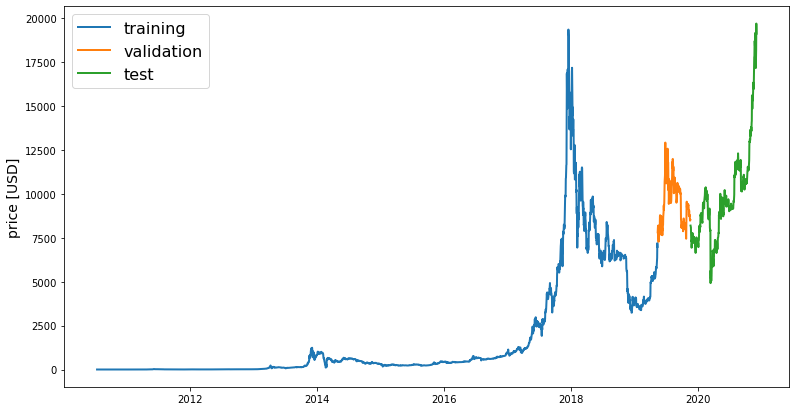

In [5]:
def line_plot(line1, line2, line3, label1=None, label2=None, label3=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.plot(line3, label=label3, linewidth=lw)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)
    
line_plot(train_df[target_col], validation_df[target_col], test_df[target_col], 'training', 'validation', 'test', title='')

In [6]:
def extract_window_data(df, window_len=5):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        window_data.append(tmp.values)
    
    return np.array(window_data)

def prepare_data(df, target_col, window_len=10):
#    train_data, validation_data, test_data = train_val_test_split(df)
#    X_train = extract_window_data(train_data, window_len)
#    X_val = extract_window_data(validation_data, window_len)
#    X_test = extract_window_data(test_data, window_len)
#    y_train = train_data[target_col][window_len:].values
#    y_val = validation_data[target_col][window_len:].values
#    y_test = test_data[target_col][window_len:].values

#    return X_train, X_val, X_test, y_train, y_val, y_test

    x = extract_window_data(df, window_len)
    y = df[target_col][window_len:].values
    
    return x, y

def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear', dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape =(input_data.shape[1],input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer)
    
    return model

In [7]:
np.random.seed(42)
window_len = 5
lstm_neurons = 100
epochs = 200
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [8]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
#mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
mc = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [9]:
#X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(df_scaled, target_col, window_len=window_len)

X_train, y_train = prepare_data(train_scaled_df, target_col, window_len=window_len)
X_val, y_val = prepare_data(validation_scaled_df, target_col, window_len=window_len)
X_test, y_test = prepare_data(test_scaled_df, target_col, window_len=window_len)

In [10]:
model = build_lstm_model(X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss, optimizer=optimizer)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=False, callbacks=[es, mc])

Epoch 1/200
100/101 [============================>.] - ETA: 0s - loss: 7.0327e-04
Epoch 00001: val_loss improved from inf to 0.00407, saving model to best_model.h5
101/101 [==============================] - 1s 11ms/step - loss: 7.0410e-04 - val_loss: 0.0041
Epoch 2/200
 99/101 [============================>.] - ETA: 0s - loss: 0.0011  
Epoch 00002: val_loss did not improve from 0.00407
101/101 [==============================] - 1s 13ms/step - loss: 0.0011 - val_loss: 0.0135
Epoch 3/200
 97/101 [===========================>..] - ETA: 0s - loss: 0.0011   
Epoch 00003: val_loss did not improve from 0.00407
101/101 [==============================] - 1s 13ms/step - loss: 0.0012 - val_loss: 0.0128
Epoch 4/200
 98/101 [============================>.] - ETA: 0s - loss: 0.0013   
Epoch 00004: val_loss did not improve from 0.00407
101/101 [==============================] - 1s 12ms/step - loss: 0.0013 - val_loss: 0.0112
Epoch 5/200
 97/101 [===========================>..] - ETA: 0s - loss: 0.0011

 97/101 [===========================>..] - ETA: 0s - loss: 2.2891e-04
Epoch 00034: val_loss improved from 0.00054 to 0.00053, saving model to best_model.h5
101/101 [==============================] - 1s 12ms/step - loss: 2.2662e-04 - val_loss: 5.2897e-04
Epoch 35/200
101/101 [==============================] - ETA: 0s - loss: 2.4030e-04
Epoch 00035: val_loss did not improve from 0.00053
101/101 [==============================] - 1s 12ms/step - loss: 2.4030e-04 - val_loss: 5.3472e-04
Epoch 36/200
 98/101 [============================>.] - ETA: 0s - loss: 2.2271e-04
Epoch 00036: val_loss did not improve from 0.00053
101/101 [==============================] - 1s 12ms/step - loss: 2.2434e-04 - val_loss: 9.9691e-04
Epoch 37/200
 98/101 [============================>.] - ETA: 0s - loss: 2.4849e-04
Epoch 00037: val_loss did not improve from 0.00053
101/101 [==============================] - 1s 12ms/step - loss: 2.4879e-04 - val_loss: 6.9669e-04
Epoch 38/200
 99/101 [============================

In [11]:
# load the best modell
model = load_model('best_model.h5')

# evaluate the model
train_acc = model.evaluate(X_train, y_train, verbose=0)
test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.000, Test: 0.000


In [12]:
preds = model.predict(X_test).squeeze()

arr = np.zeros([preds.shape[0], 6])
arr[:, 5] = preds

res = scaler.inverse_transform(arr)

df_res = pd.DataFrame(res, columns=df.columns)

df_res.head()

,high,low,open,volumefrom,volumeto,close
0,0.04951,0.01,0.04951,0.0,0.0,7386.330021
1,0.04951,0.01,0.04951,0.0,0.0,7352.458928
2,0.04951,0.01,0.04951,0.0,0.0,7189.027402
3,0.04951,0.01,0.04951,0.0,0.0,7107.465575
4,0.04951,0.01,0.04951,0.0,0.0,7271.741154


In [13]:
res

array([[4.95100000e-02, 1.00000000e-02, 4.95100000e-02, 0.00000000e+00,
        0.00000000e+00, 7.38633002e+03],
       [4.95100000e-02, 1.00000000e-02, 4.95100000e-02, 0.00000000e+00,
        0.00000000e+00, 7.35245893e+03],
       [4.95100000e-02, 1.00000000e-02, 4.95100000e-02, 0.00000000e+00,
        0.00000000e+00, 7.18902740e+03],
       ...,
       [4.95100000e-02, 1.00000000e-02, 4.95100000e-02, 0.00000000e+00,
        0.00000000e+00, 1.69190585e+04],
       [4.95100000e-02, 1.00000000e-02, 4.95100000e-02, 0.00000000e+00,
        0.00000000e+00, 1.74210269e+04],
       [4.95100000e-02, 1.00000000e-02, 4.95100000e-02, 0.00000000e+00,
        0.00000000e+00, 1.86116215e+04]])

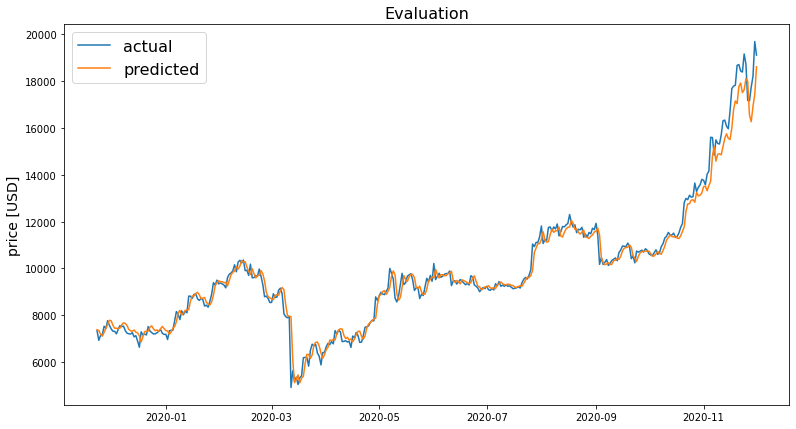

In [14]:
predicted_closing_prices = df_res[target_col].values
actual_closing_prices = test_df[target_col][window_len:]
predicted_closing_prices = pd.Series(index=actual_closing_prices.index, data=predicted_closing_prices)

fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(actual_closing_prices, label='actual')
ax.plot(predicted_closing_prices, label='predicted')
ax.set_ylabel('price [USD]', fontsize=14)
ax.set_title('Evaluation', fontsize=16)
ax.legend(loc='best', fontsize=16)
plt.show()

In [22]:
res_data = {'time': test_df.index[window_len:], 'actual': test_df[target_col][window_len:], 'preds' :predicted_closing_prices}
res_df = pd.DataFrame(data=res_data)

In [23]:
res_df.head()

,time,actual,preds
time,,,
2019-11-23,2019-11-23,7339.24,7386.330021
2019-11-24,2019-11-24,6930.09,7352.458928
2019-11-25,2019-11-25,7138.23,7189.027402
2019-11-26,2019-11-26,7170.11,7107.465575
2019-11-27,2019-11-27,7531.50,7271.741154


In [24]:
res_df.to_json(r'results.json')